In [14]:
import torchvision.models as models
import json
import argparse
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sb

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data.sampler import SequentialSampler

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from tqdm import tqdm

from IPython.display import Image

In [2]:
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))
print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_weight', 'googlenet', 'inception_v3', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1

In [3]:
model = models.__dict__['resnet50'](pretrained=True, num_classes=1000)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [4]:
activations = []
def save_activation(mod, inp, out):
    activations.append(out.view(out.shape[0], -1).detach().numpy())

name, module = list(model.named_modules())[-2]
print(f'Extracting output states from {name}:{module}')
module.register_forward_hook(save_activation)

Extracting output states from avgpool:AdaptiveAvgPool2d(output_size=(1, 1))


In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1v-KitwrisSYJU51b3vPMAKr1rVRbrirl' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1v-KitwrisSYJU51b3vPMAKr1rVRbrirl" -O toy_imagenet.zip && rm -rf /tmp/cookies.txt


--2022-11-28 17:48:55--  https://docs.google.com/uc?export=download&confirm=t&id=1v-KitwrisSYJU51b3vPMAKr1rVRbrirl
Resolving docs.google.com (docs.google.com)... 209.85.200.100, 209.85.200.113, 209.85.200.139, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mkit8l4da95r2uat0r3per8ned51akin/1669657725000/07900730216187465587/*/1v-KitwrisSYJU51b3vPMAKr1rVRbrirl?e=download&uuid=4a6b5391-8d07-43fb-a638-9a85f18a8656 [following]
--2022-11-28 17:48:55--  https://doc-08-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mkit8l4da95r2uat0r3per8ned51akin/1669657725000/07900730216187465587/*/1v-KitwrisSYJU51b3vPMAKr1rVRbrirl?e=download&uuid=4a6b5391-8d07-43fb-a638-9a85f18a8656
Resolving doc-08-08-docs.googleusercontent.com (doc-08-08-docs.googleusercontent.com)... 142.250.159.132,

In [6]:
!unzip toy_imagenet.zip


Archive:  toy_imagenet.zip
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00035774.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00024940.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00008848.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00037050.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00015220.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00004329.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00030127.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00014467.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00019409.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00039304.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00020011.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00034950.JPEG  
  inflating: toy_imagenet/great_white_shark/ILSVRC2012_val_00023185.JPEG 

In [7]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
  dataset = datasets.ImageFolder('toy_imagenet',
                                      transforms.Compose([transforms.Resize(int(224 * 1.14)),
                                                          transforms.CenterCrop(224),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])]))
  loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8,
                                            pin_memory=True, sampler=SequentialSampler(dataset))
  for idx, (ims, targets) in enumerate(loader):
    print(idx*50)
    
    all_targets.append(targets)
    logits = model(ims)
    predictions = torch.argmax(logits, dim=-1).detach().numpy()
    all_preds.append(predictions)
predictions = np.concatenate(all_preds)
labels = torch.cat(all_targets).detach().numpy()
imvecs = np.concatenate(activations[-8:])
print(imvecs.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
250
300
350
(400, 2048)


In [8]:
print(predictions.shape)
print(labels.shape)
print(imvecs.shape)
print(len(activations))

(400,)
(400,)
(400, 2048)
8


In [9]:
import pandas as pd
df = pd.DataFrame(columns=['label', 'prediction', 'cluster', 'path'])
df['prediction'] = predictions
df['label'] = labels
paths = [img[0] for img in dataset.imgs]
df['path'] = paths

In [10]:
last_score = -2.
score = -1.
scaler = StandardScaler()
scaler.fit(imvecs)
X = scaler.transform(imvecs)
# #############################################################################
n_clusters = 2


# while score > last_score:
for i in range(2,10):
  print(f'Fitting to {n_clusters} clusters')
  last_score = score
  kmeans = KMeans(n_clusters=n_clusters, random_state=200)
  kmeans.fit(X)
  labels = kmeans.predict(X)
  score = metrics.silhouette_score(X, labels)
  if score > last_score: 
    best_model = kmeans
    best_labels = labels
  n_clusters += 1
  print(f'score: {score}')


Fitting to 2 clusters
score: 0.06556954234838486
Fitting to 3 clusters
score: 0.07472790032625198
Fitting to 4 clusters
score: 0.0810966044664383
Fitting to 5 clusters
score: 0.10561311990022659
Fitting to 6 clusters
score: 0.11562288552522659
Fitting to 7 clusters
score: 0.12892228364944458
Fitting to 8 clusters
score: 0.1410834640264511
Fitting to 9 clusters
score: 0.13004054129123688


In [11]:
df['cluster'] = best_labels

In [12]:

df

label  prediction  cluster  \
0        0         981        2   
1        0         489        2   
2        0         981        2   
3        0         429        2   
4        0         981        2   
..     ...         ...      ...   
395      7         970        1   
396      7         980        1   
397      7         980        1   
398      7         980        1   
399      7         980        1   

                                                  path  
0    toy_imagenet/ballplayer/ILSVRC2012_val_0000003...  
1    toy_imagenet/ballplayer/ILSVRC2012_val_0000210...  
2    toy_imagenet/ballplayer/ILSVRC2012_val_0000225...  
3    toy_imagenet/ballplayer/ILSVRC2012_val_0000228...  
4    toy_imagenet/ballplayer/ILSVRC2012_val_0000275...  
..                                                 ...  
395  toy_imagenet/volcano/ILSVRC2012_val_00044072.JPEG  
396  toy_imagenet/volcano/ILSVRC2012_val_00045671.JPEG  
397  toy_imagenet/volcano/ILSVRC2012_val_00046275.JPEG  
398  toy_imagenet/volcano/ILSVRC2012_val_00046697.JPEG  
399  toy_imagenet/volcano/ILSVRC2012_val_00048040.JPEG  

[400 rows x 4 columns]

Confusion matrix:
[[ 0  0 49  0  0  0  0  1]
 [ 0  0  0 50  0  0  0  0]
 [ 1  0  0  0  0 46  0  3]
 [50  0  0  0  0  0  0  0]
 [ 0  0  1  0 49  0  0  0]
 [ 0  0  0  1  0  0  1 48]
 [ 0  0  0  0  0  0 50  0]
 [ 2 47  0  0  0  1  0  0]]


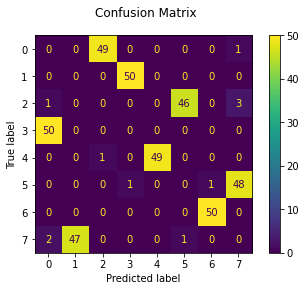

In [15]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(df['label'], df['cluster'])
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()
# plt.hist(data=df2, x='label', y='cluster')

(array([53., 47., 50.,  0., 51., 49.,  0., 47., 51., 52.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 1 Patch objects>)

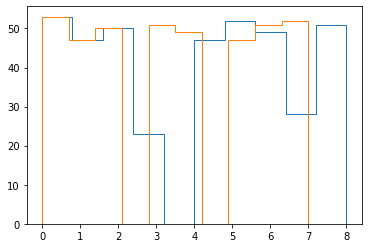

In [16]:
plt.hist(labels, histtype='step')
plt.hist(best_labels, histtype='step')

* T0: ballplayer
* P0: dome
* T1: burrito
* P1: volcano
* T2: candle
* P2: ballplayer
* T3: dome
* P3: burrito
* T4: shark
* P4: shark
* T5: grocery store
* P5: candle
* T6: sea urchin
* P6: sea urchin
* T7: volcano
* P7: grocery store

In [18]:
print(metrics.classification_report(labels, best_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        47
           5       0.02      0.02      0.02        52
           6       0.00      0.00      0.00        49
           7       0.02      0.04      0.03        28
           8       0.00      0.00      0.00        51

    accuracy                           0.14       400
   macro avg       0.12      0.12      0.12       400
weighted avg       0.14      0.14      0.14       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


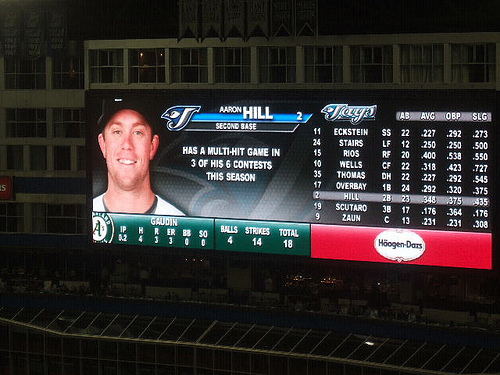

In [19]:
# True    : Ball Player
# Predict : Grocery Store
# Why?    : Image shows a billboard with a ball player
#           I do see a HaggenDas advert 
#           and it's possible the lighting aspect may be interpreted as a storefront
df[(df["label"] == 0) & (df["cluster"] == 7)]
Image(filename="toy_imagenet/ballplayer/ILSVRC2012_val_00036209.JPEG")

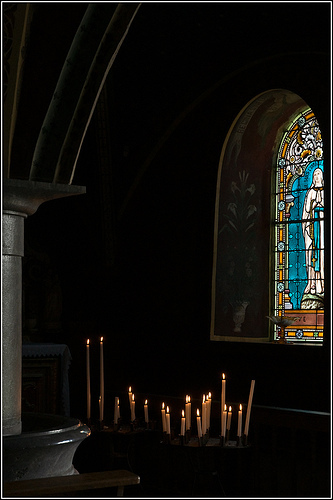

In [20]:
# True    : Candle
# Predict : Dome
# Why?    : Image shows both candle and a dome shaped window

df[(df["label"] == 2) & (df["cluster"] == 0)]
Image(filename="toy_imagenet/candle/ILSVRC2012_val_00034517.JPEG")

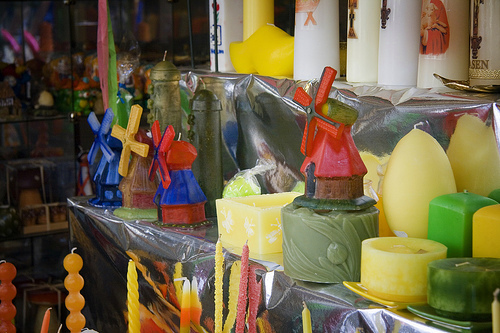

In [21]:
# True    : Candle
# Predict : Grocery Store
# Why?    : Image shows Candles of varying types, 
#           Possibly confused by the bright and varried colors and shapes which migh be mistaken for produce. 
df[(df["label"] == 2) & (df["cluster"] == 7)]
Image(filename="toy_imagenet/candle/ILSVRC2012_val_00041434.JPEG")

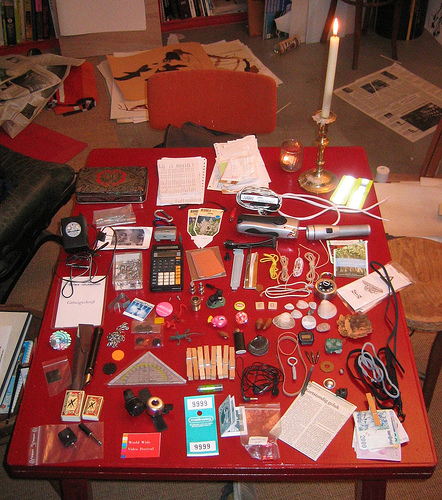

In [22]:
# True    : Candle
# Predict : Grocery Store
# Why?    : There is a candle in the image, 
#           Image also shows a scattering of objects on a table, 
#           perhaps the algorithm thinks it's some kind of bazaar. 
df[(df["label"] == 2) & (df["cluster"] == 7)]
Image(filename="toy_imagenet/candle/ILSVRC2012_val_00038456.JPEG")

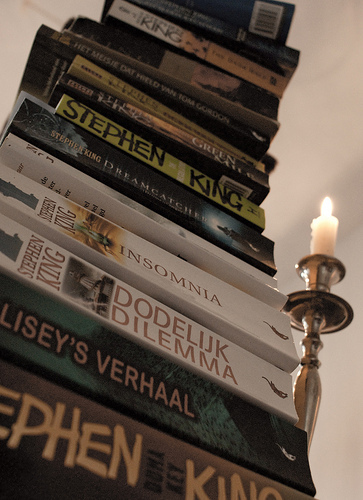

In [23]:
# True    : Candle
# Predict : Grocery Store
# Why?    : There is a candle in the image, 
#           Image also shows a stack of books which may be confused for a bookstore. 
df[(df["label"] == 2) & (df["cluster"] == 7)]
Image(filename="toy_imagenet/candle/ILSVRC2012_val_00002596.JPEG")

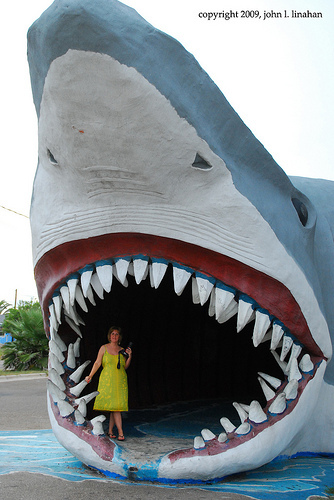

In [24]:
# True    : Shark
# Predict : Ball Player
# Why?    : Image shows a shark
#           Maybe it sees the shark as part of a close up on a uniform like a logo or something. 
#           Maybe the algorithm sees the teeth and thinks stadium? or Diamond plate or something...
df[(df["label"] == 4) & (df["cluster"] == 2)]     
Image(filename="toy_imagenet/great_white_shark/ILSVRC2012_val_00017105.JPEG")

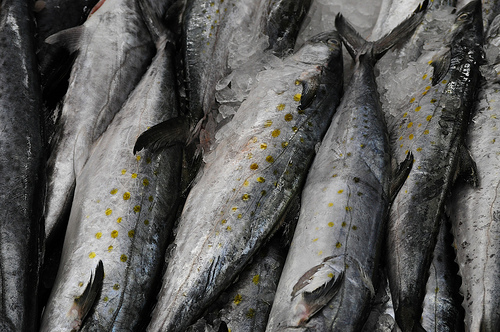

In [25]:
# True    : Grocery Store
# Predict : Burrito
# Why?    : Image shows a fish section of a grocery store
#           The fish may bear some shade and shape resemblance to burritos in a greyscale image...
df[(df["label"] == 5) & (df["cluster"] == 3)]
Image(filename="toy_imagenet/grocery_store/ILSVRC2012_val_00042138.JPEG")

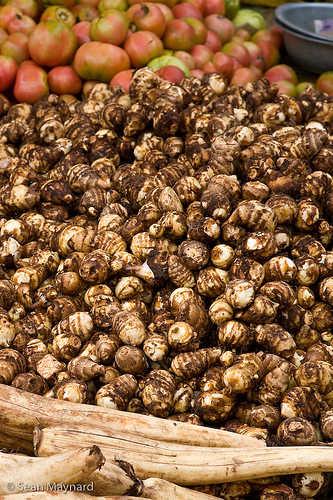

In [26]:
# True    : Grocery Store
# Predict : Sea Urchin
# Why?    : Looks like a produce lane
#           The mass could be considered some kind of grubby limbed urchin or anemone 
df[(df["label"] == 5) & (df["cluster"] == 6)]
Image(filename="toy_imagenet/grocery_store/ILSVRC2012_val_00003568.JPEG")

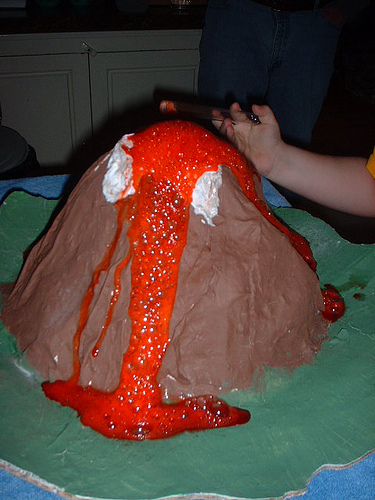

In [27]:
# True    : Volcano
# Predict : Candle
# Why?    : Image shows a paper mache volcano, 
#           The red is probably throwing off the algorithm as it could be interpreted as fire
#           also if you took the shilluette of the central collumn of "lava"
#           and added the shilluette of the end of that pipe it could concievably be construed as a candle, pool of wax included. 
df[(df["label"] == 7) & (df["cluster"] == 5)]
Image(filename="toy_imagenet/volcano/ILSVRC2012_val_00029608.JPEG")

In [28]:
# True    : Volcano
# predict : Dome
# Why?    : Image shows a volcano
#           The dome-shaped volcano is dome-shaped
df[(df["label"] == 7) & (df["cluster"] == 0)]
Image(filename="toy_imagenet/volcano/ILSVRC2012_val_00023470.JPEG")

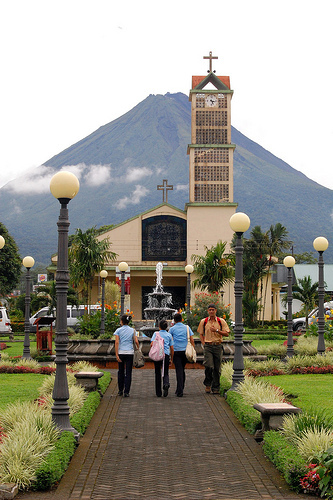

In [29]:
# True    : Volcano
# predict : Dome
# Why?    : Image shows both candle and dome
#           The dome-shaped volcano still looks dome-shaped... 
#           now it just looks like a church dome
df[(df["label"] == 7) & (df["cluster"] == 0)]
Image(filename="toy_imagenet/volcano/ILSVRC2012_val_00031323.JPEG")

In [ ]:
''' 
It seems like generally things get confused with dome as it is a shape and can describe many different things distributed across the whole dataset. 
A majority of the mistakes were catching shapes out of objects and interpreting them as that shape. 
Humans have the capacity to fill in gaps that divide catigories, while the computer seems to rely on shapes and physical properties. 

'''